# Desicion Tree and Random Forests
ここではノンパラメトリックなアルゴリズムであるランダムフォレストを見ていく。ランダムフォレストはアンサンブル法の例である。アンサンブル法はシンプルな予測器の案サンプルの結果を統合する。そのようなアンサンブル法を用いた時の結果は個別のそれよりも優れた結果となる。多数決で決まる予測は個別の予測よりも優れたものとなる。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
%%file helpers_05_08.py

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact


def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
             zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis',
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_
        
            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)
        
            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)


def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 5])


def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())
    
    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False,
                       xlim=xlim, ylim=ylim)
    
    interact(fit_randomized_tree, random_state=[0, 100]);

Overwriting helpers_05_08.py


## ランダムフォレストのモチベーション：決定木
ランダムフォレストは決定木からならアンサンブル学習機の一つの例である。そのため、決定木そのものの説明を行う。

決定木は単純に連続したいくつかの問いで分類を行うものである。

[0, 1, 0, 1]

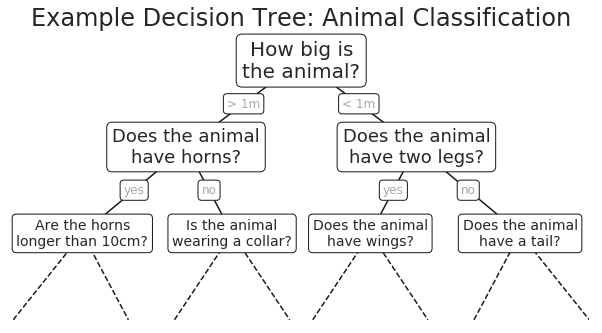

In [3]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0, 0, 0.8, 1], frameon=False, xticks=[], yticks=[])
ax.set_title('Example Decision Tree: Animal Classification', size=24)

def text(ax, x, y, t, size=20, **kwargs):
    ax.text(x, y, t,
            ha='center', va='center', size=size,
            bbox=dict(boxstyle='round', ec='k', fc='w'), **kwargs)

text(ax, 0.5, 0.9, "How big is\nthe animal?", 20)
text(ax, 0.3, 0.6, "Does the animal\nhave horns?", 18)
text(ax, 0.7, 0.6, "Does the animal\nhave two legs?", 18)
text(ax, 0.12, 0.3, "Are the horns\nlonger than 10cm?", 14)
text(ax, 0.38, 0.3, "Is the animal\nwearing a collar?", 14)
text(ax, 0.62, 0.3, "Does the animal\nhave wings?", 14)
text(ax, 0.88, 0.3, "Does the animal\nhave a tail?", 14)

text(ax, 0.4, 0.75, "> 1m", 12, alpha=0.4)
text(ax, 0.6, 0.75, "< 1m", 12, alpha=0.4)

text(ax, 0.21, 0.45, "yes", 12, alpha=0.4)
text(ax, 0.34, 0.45, "no", 12, alpha=0.4)

text(ax, 0.66, 0.45, "yes", 12, alpha=0.4)
text(ax, 0.79, 0.45, "no", 12, alpha=0.4)

ax.plot([0.3, 0.5, 0.7], [0.6, 0.9, 0.6], '-k')
ax.plot([0.12, 0.3, 0.38], [0.3, 0.6, 0.3], '-k')
ax.plot([0.62, 0.7, 0.88], [0.3, 0.6, 0.3], '-k')
ax.plot([0.0, 0.12, 0.20], [0.0, 0.3, 0.0], '--k')
ax.plot([0.28, 0.38, 0.48], [0.0, 0.3, 0.0], '--k')
ax.plot([0.52, 0.62, 0.72], [0.0, 0.3, 0.0], '--k')
ax.plot([0.8, 0.88, 1.0], [0.0, 0.3, 0.0], '--k')
ax.axis([0, 1, 0, 1])

基本的に2分木で作られる。良く作られた決定木ではひとつの問いで約半分に分けられるように作られる。機械学習での決定木の実装では、一般的にデータを分割するのに、軸に沿った形で行われる。つまり、ツリーのそれぞれのノードで一つの特徴の値の閾値を利用して2つのグループに分けられる。

## 決定木の作成

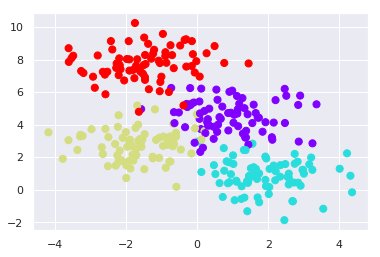

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

このデータに対する単純な2分木はある定量的な基準に則って軸に沿ってデータを分割していく。



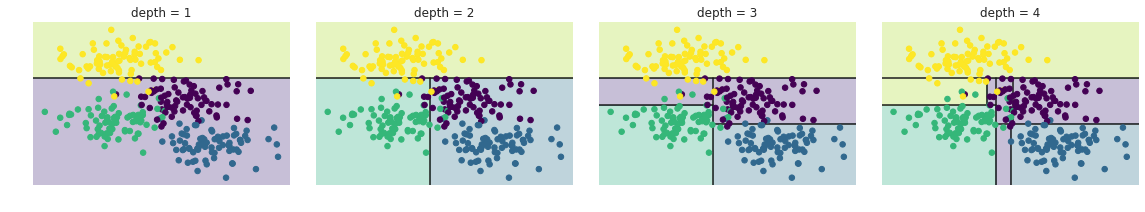

In [5]:
from helpers_05_08 import visualize_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs

        
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

for axi, depth in zip(ax, range(1, 5)):
    model = DecisionTreeClassifier(max_depth=depth)
    visualize_tree(model, X, y, ax=axi)
    axi.set_title('depth = {0}'.format(depth))

始めの分割で、上部は完全に1つのグループに分割されているため、上部はこれ以上分割する必要はない。下部はまだいくつかのグループが含まれているため、繰り返し分割していく。

このプロセスは`DecisionTreeClassifier`が利用できる。

In [6]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [7]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap,
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

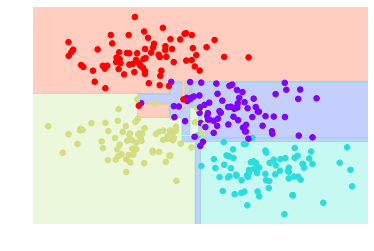

In [8]:
visualize_classifier(DecisionTreeClassifier(), X, y)

ツリーの深さが増えるにつれ、不思議な形の分類の領域が得られていることが分かる。例えば、深さが5の場合細長い紫色の領域が黄色と青の間にある。これは、このツリーが深すぎてオーバーフィッティングであるからである。

### 決定木とオーバーフィッティング
このようなオーバーフィッティングは決定木でよく見られるものである。例えばデータセットを変えればまたことなる分割となる。

ある部分においては2つの別々のツリーが同じ結果を生成し、異なる部分ではそれぞれ別の分類を与えることが考えられる。なので、それぞれのツリーの情報を使えば、よりよい結果が得られることが考えられる。

In [9]:
import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', index=1, options=(1, 5), value=5), Output()), _dom_classes…

## 予測器のアンサンブル：ランダムフォレスト
複数のオーバーフィッティングな予測器はこのオーバーフィットの効果を減らすためにまとめることが出来る。これはバギングと呼ばれるアンサンブル法にあるものだ。バギングは複数の予測器のアンサンブルを使用して、よりよい分類器を探すものである。ランダム化された決定木のアンサンブルはランダムフォレストとして知られる。

この種のバギングは`BaggingClassifier`を使用して手動で行うことが出来る。

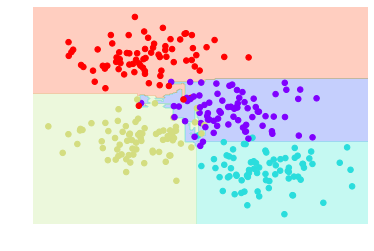

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

この例では、学習点の80%のランダムなサブセットでそれぞれの分類器をフィットすることでデータをランダム化している。実際は、決定木は分割の仕方にある確率性の与えることでより効率的にランダム化することである。この方法ではそれぞれのフィットの時に全てのデータを寄与させることができるが、その結果は望んだランダム性をもつフィットとなる。例えば、どの特徴を分割するか決めるとき、ランダム化されたツリーはいくつかのトップの間から選択する。より詳細なものはScikit-Learnのドキュメンテーションを参照。

Scikit-Learnでは、ランダム化された決定木の適切なアンサンブルが`RandomForestClassifier`で実装されおり、すべてのランダム性を自動的に気にかけてくれる。必要なのは分類器の数（ツリーの数）だけである。

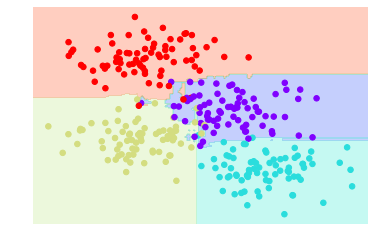

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

## ランダムフォレスト回帰
ランダムフォレストは回帰にも使用できる。

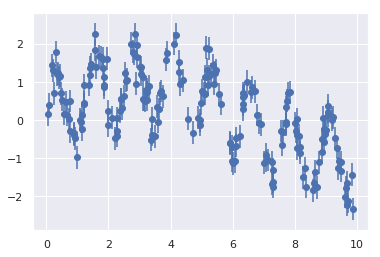

In [12]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

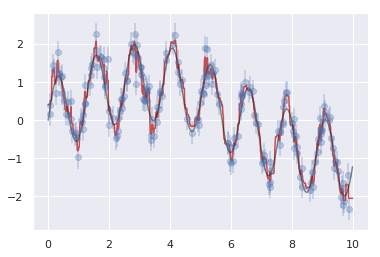

In [13]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(100, min_samples_split=2)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.3)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

## 例：数字分類のためのランダムフォレスト
8x8ピクセルの数字を分類する。特徴点はそれぞれのピクセルとして、64個の特徴点となる。これをランダムフォレストで10個に分類する。

In [14]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

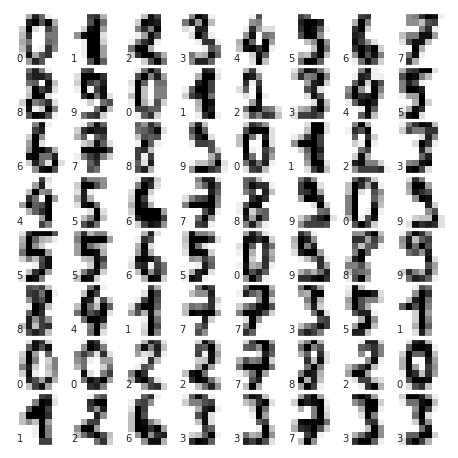

In [15]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [16]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [17]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.95      0.97        44
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.96      0.96      0.96        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.96      0.97        48

   micro avg       0.98      0.98      0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



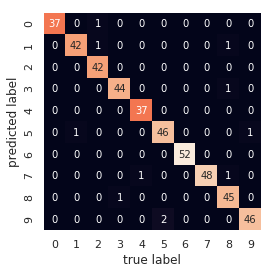

In [18]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## ランダムフォレストのまとめ
- 学習と予測がとても速い。なぜなら決定木の基礎がシンプルであるため。くわえて、個別のツリーは完全に独立なものであるため、それぞれのタスクが簡単に並列化できる。
- 複数のツリーは確率的な分類も可能とする。多数決の割合で確率も予測できる。（`predict_proba()`でアクセス可能）
- ノンパラメトリックなモデルはとても柔軟で、他の分類器ではアンダーフィットとなるタスクでもうまく機能する

ランダムフォレストの欠点となり宇布野はその結果が簡単に理解できない点である。つまり、分類モデルの意味の結論を描画したいとしたならば、ランダムフォレストは最適な選択でない。